In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, r2_score, explained_variance_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import Lasso

import torch
from torch import nn
import torch.nn.functional as F

#from dp_wgan import Generator, Discriminator
#from dp_autoencoder import Autoencoder
#from evaluation import *
#import dp_optimizer, sampling, analysis, evaluation

torch.manual_seed(0)
np.random.seed(0)

In [2]:
class Processor:
    def __init__(self, datatypes):
        self.datatypes = datatypes
        
    def fit(self, matrix):
        preprocessors, cutoffs = [], []
        for i, (column, datatype) in enumerate(self.datatypes):
            preprocessed_col = matrix[:,i].reshape(-1, 1)

            if 'categorical' in datatype:
                preprocessor = LabelBinarizer()
            else:
                preprocessor = MinMaxScaler()

            preprocessed_col = preprocessor.fit_transform(preprocessed_col)
            cutoffs.append(preprocessed_col.shape[1])
            preprocessors.append(preprocessor)
        
        self.cutoffs = cutoffs
        self.preprocessors = preprocessors
    
    def transform(self, matrix):
        preprocessed_cols = []
        
        for i, (column, datatype) in enumerate(self.datatypes):
            preprocessed_col = matrix[:,i].reshape(-1, 1)
            preprocessed_col = self.preprocessors[i].transform(preprocessed_col)
            preprocessed_cols.append(preprocessed_col)

        return np.concatenate(preprocessed_cols, axis=1)

        
    def fit_transform(self, matrix):
        self.fit(matrix)
        return self.transform(matrix)
            
    def inverse_transform(self, matrix):
        postprocessed_cols = []

        j = 0
        for i, (column, datatype) in enumerate(self.datatypes):
            postprocessed_col = self.preprocessors[i].inverse_transform(matrix[:,j:j+self.cutoffs[i]])

            if 'categorical' in datatype:
                postprocessed_col = postprocessed_col.reshape(-1, 1)
            else:
                if 'positive' in datatype:
                    postprocessed_col = postprocessed_col.clip(min=0)

                if 'int' in datatype:
                    postprocessed_col = postprocessed_col.round()

            postprocessed_cols.append(postprocessed_col)
            
            j += self.cutoffs[i]
        
        return np.concatenate(postprocessed_cols, axis=1)

In [3]:
datatypes = [
    ('age', 'positive int'),
    ('workclass', 'categorical'),
    ('fnlwgt','positive int'),
    ('education', 'categorical'),
    ('education-num', 'categorical'),
    ('marital-status', 'categorical'),
    ('occupation', 'categorical'),
    ('relationship', 'categorical'),
    ('race', 'categorical'),
    ('sex', 'categorical binary'),
    ('capital-gain', 'positive float'),
    ('capital-loss', 'positive float'),
    ('hours-per-week', 'positive int'),
    ('native-country', 'categorical'),
    ('salary', 'categorical binary'),
]

datatypes_ours = [
    ('age', 'positive int'),
    ('workclass', 'categorical'),
    ('education-num', 'categorical'),
    ('marital-status', 'categorical'),
    ('occupation', 'categorical'),
    ('relationship', 'categorical'),
    ('race', 'categorical'),
    ('sex', 'categorical binary'),
    ('capital-gain', 'positive float'),
    ('capital-loss', 'positive float'),
    ('hours-per-week', 'positive int'),
    ('native-country', 'categorical'),
    ('salary', 'categorical binary'),
]


# Histogram of sparse columns of ours, DP-VAE, DP-WGAN, DP_SYN


## Original data and pre- and post-processing

In [4]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
train = pd.read_csv('adult.data', names=names)
test = pd.read_csv('adult.test', names=names)

ori_df = pd.concat([train, test])

In [5]:
def get_dist(dataframe,column):
    '''
    Return the frequency of each category in the column of dataframe. 
    It is assumed to be a categorical, as the method will call 'strip()' to ignore the difference in the extra spaces
    
    Return:
        pandas series. E.g.
        United-States 0.7
        Others 0.3
    '''
    return (dataframe[column].str.strip()).value_counts()/len(dataframe)

In [6]:
#example
get_dist(ori_df,'native-country')

United-States                 0.897424
Mexico                        0.019471
?                             0.017546
Philippines                   0.006040
Germany                       0.004218
Puerto-Rico                   0.003767
Canada                        0.003726
El-Salvador                   0.003173
India                         0.003092
Cuba                          0.002825
England                       0.002600
China                         0.002498
South                         0.002355
Jamaica                       0.002170
Italy                         0.002150
Dominican-Republic            0.002109
Japan                         0.001884
Guatemala                     0.001802
Poland                        0.001781
Vietnam                       0.001761
Columbia                      0.001740
Haiti                         0.001536
Portugal                      0.001372
Taiwan                        0.001331
Iran                          0.001208
Nicaragua                

In [7]:
#create pre and post processing
map_back_ori = {}
map_forward_ori = {}
ori_df_processed = ori_df.copy()
for column, datatype in datatypes:
    if 'categorical' in datatype:
        series = ori_df[column].astype('category')
        ori_df_processed[column] = series.cat.codes
        map_back_ori[column] = dict(enumerate(series.cat.categories)) # e.g. 9 --> 'USA'
        map_forward_ori[column] = dict(map(reversed, map_back_ori[column].items())) #e.g. 'USA' --> 9 

In [8]:
#ori_df_processed is just to preprocessed our data
p = Processor(datatypes_ours)
p.fit(ori_df_processed.drop(columns=['fnlwgt','education']).values)
our_cols = names.copy()
our_cols.remove('fnlwgt')
our_cols.remove('education')

ours1 = pd.read_csv('synthetic_ae_0_2_gan_0_3.csv',index_col='Unnamed: 0')
ours2 = pd.read_csv('synthetic_ae_0_4_gan_0_4.csv',index_col='Unnamed: 0')
ours3 = pd.read_csv('synthetic_ae_0_7_gan_0_7.csv',index_col='Unnamed: 0')
ours_all = [ours1, ours2, ours3]
for i in range(len(ours_all)):
    ours_all[i] = p.inverse_transform(ours_all[i].values)
    ours_all[i] = pd.DataFrame(ours_all[i], columns=our_cols)

    for column, datatype in datatypes_ours:
        if 'categorical' in datatype:
            ours_all[i][column] = ours_all[i][column].map(map_back_ori[column])

C:\Users\uthai\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\uthai\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\uthai\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\uthai\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Anderson's WGAN

In [9]:
#version with bigger epsilon. 
wgan_all = [pd.read_csv('anderson_wgan/noise_19_0_5.csv'),
            pd.read_csv('anderson_wgan/noise_11_0_8.csv'),
            pd.read_csv('anderson_wgan/noise_7_1_4.csv') ]
for i in range(len(wgan_all)):
    wgan_all[i] = wgan_all[i].rename(columns={'output':'salary'})
get_dist(wgan_all[2],'salary') #example

Tru    0.965034
Fal    0.034966
Name: salary, dtype: float64

In [10]:
wgan_all2 = [pd.read_csv('anderson_wgan/noise_27.5_0_35.csv'),
            pd.read_csv('anderson_wgan/noise_19_0_5.csv'),
            pd.read_csv('anderson_wgan/noise_9_1_0.csv') ]
for i in range(len(wgan_all2)):
    wgan_all2[i] = wgan_all2[i].rename(columns={'output':'salary'})
    wgan_all2[i]['salary'] = (wgan_all2[i]['salary'].astype('category').cat.codes).map({1:'>50K',0:'<=50K'})

# DP-VAE

In [11]:
#version with higher epsilon if we want to compare
vae_all = [pd.read_csv('dp-vae/adult_0_5_full_n.csv'),
           pd.read_csv('dp-vae/adult_0_8_full_n.csv'),
           pd.read_csv('dp-vae/adult_1_4_full_n.csv') ]
get_dist(vae_all[2],'race') #example

White                 0.711846
Black                 0.107919
Asian-Pac-Islander    0.063368
Amer-Indian-Eskimo    0.062610
Other                 0.054257
Name: race, dtype: float64

In [12]:
#correct epsilon
vae_all2 = [pd.read_csv('dp-vae/adult_0.36_noise_5.csv'),
           pd.read_csv('dp-vae/adult_0.51_noise_4.csv'),
           pd.read_csv('dp-vae/adult_1.01_noise_2.csv') ]
for i in range(len(vae_all2)):
    vae_all2[i] = vae_all2[i].rename(columns={'income':'salary'})
    vae_all2[i]['salary'] = (vae_all2[i]['salary'].astype('category').cat.codes).map({1:'>50K',0:'<=50K'})

# DP-SYN (Abay)

In [13]:
abay_all = [pd.read_csv('Abay/_0.5_4_1.txt'),
            pd.read_csv('Abay/_0.8_4_1.txt'),
            pd.read_csv('Abay/_1.4_4_1.txt') ]
for i in range(len(abay_all)):
    #need to map column to the same name
    abay_all[i] = abay_all[i].rename(columns={'country':'native-country','marital':'marital-status','income':'salary'})
    abay_all[i]['salary'] = (abay_all[i]['salary'].astype('category').cat.codes).map({1:'>50K',0:'<=50K'})

get_dist(abay_all[1],'native-country')

#our preprocessing version
abay_all_our_pre = [pd.read_csv('Abay/our-preprocess/_0.5_6_1.txt'),
            pd.read_csv('Abay/our-preprocess/_0.8_4_1.txt'),
            pd.read_csv('Abay/our-preprocess/_1.4_4_1.txt') ] #our preprocessing of Abay
#post processing from ours
for i in range(len(abay_all_our_pre)):
    abay_all_our_pre[i] = p.inverse_transform(abay_all_our_pre[i].values)
    abay_all_our_pre[i] = pd.DataFrame(abay_all_our_pre[i], columns=our_cols)

    for column, datatype in datatypes_ours:
        if 'categorical' in datatype:
            abay_all_our_pre[i][column] = abay_all_our_pre[i][column].map(map_back_ori[column])
abay_all_our_pre[0]

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,23.0,Self-emp-not-inc,14,Never-married,Adm-clerical,Not-in-family,White,Male,999.99,348.48,49.0,United-States,<=50K
1,55.0,Self-emp-not-inc,1,Married-civ-spouse,Exec-managerial,Not-in-family,White,Female,18999.81,784.08,57.0,Holand-Netherlands,>50K
2,23.0,Local-gov,9,Never-married,Adm-clerical,Not-in-family,White,Female,0.00,348.48,27.0,United-States,<=50K
3,23.0,Private,7,Never-married,Adm-clerical,Not-in-family,White,Female,0.00,43.56,26.0,United-States,<=50K
4,23.0,?,10,Separated,Prof-specialty,Husband,White,Female,0.00,304.92,26.0,United-States,<=50K
5,34.0,Without-pay,9,Married-civ-spouse,Prof-specialty,Wife,White,Female,18999.81,0.00,34.0,Outlying-US(Guam-USVI-etc),>50K
6,23.0,?,9,Never-married,Other-service,Husband,White,Female,999.99,348.48,51.0,United-States,<=50K
7,51.0,Private,9,Never-married,Craft-repair,Husband,White,Male,999.99,0.00,51.0,United-States,<=50K
8,34.0,Never-worked,1,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00,784.08,34.0,United-States,>50K
9,23.0,Private,9,Never-married,Adm-clerical,Not-in-family,White,Female,0.00,348.48,41.0,United-States,<=50K


# Combine them

In [14]:
import matplotlib
matplotlib.style.use('ggplot')

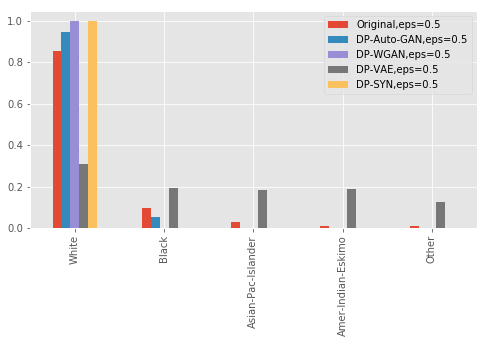

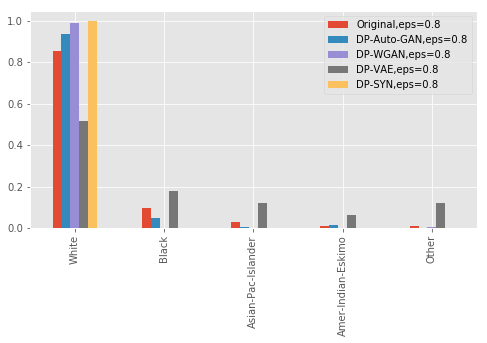

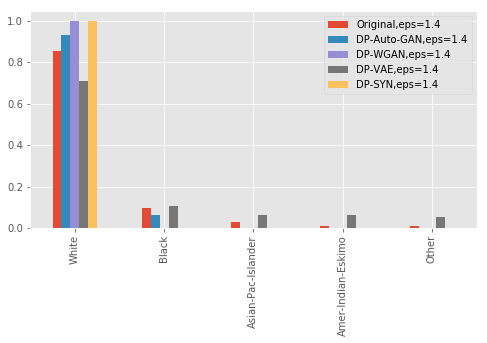

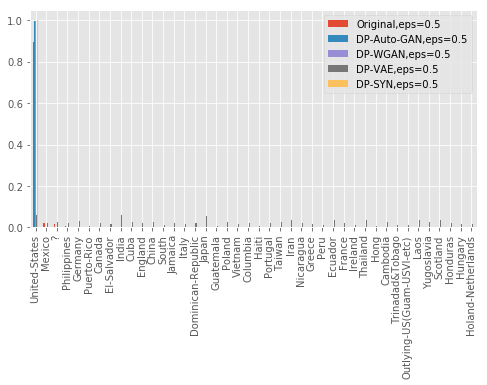

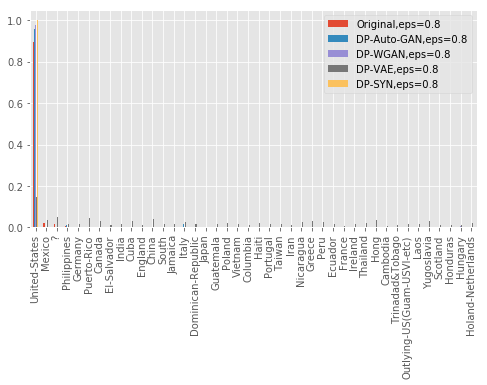

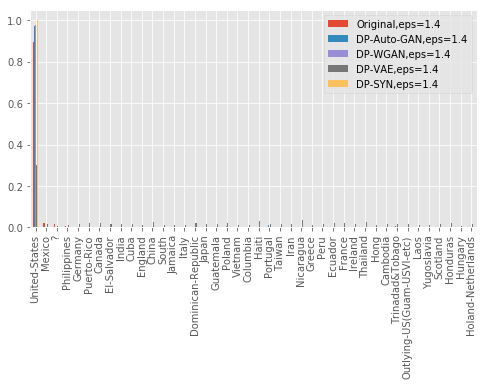

In [15]:
#example
all_eps=[0.5,0.8,1.4] #three eps setting
for column in ['race','native-country']:
    for i in range(len(all_eps)):
        freq = get_dist(ori_df,column).rename('Original,eps='+str(all_eps[i])).to_frame()\
            .join(get_dist(ours_all[i],column).rename('DP-Auto-GAN,eps='+str(all_eps[i])).to_frame())\
            .join(get_dist(wgan_all[i],column).rename('DP-WGAN,eps='+str(all_eps[i])).to_frame())\
            .join(get_dist(vae_all[i],column).rename('DP-VAE,eps='+str(all_eps[i])).to_frame())\
            .join(get_dist(abay_all[i],column).rename('DP-SYN,eps='+str(all_eps[i])).to_frame())
        freq.plot(kind='bar',figsize=(8, 4))

In [16]:
if not os.path.isdir('hist_plot'):
    os.makedirs('hist_plot/')

In [17]:
#plot by eps
os.path.isdir('hist_plot')

def plot_by_eps(ori_df,dataframes,columns,dataframes_names,prefix='hist_plot/'):
    '''
    Put in a list of dataframes, with the list of names to each one.
    Input a list of columns in both ori_df and dataframes to compare side by side, across different dataframes
    e.g.
    plot_by_eps(ori_df,[df1,df2,df3],['race','native-country'],['eps=0.5','eps=0.8','eps=1.4'])
    
    It will save all the pictures to prefix hist_plot/. Can add or change the destination name as needed.
    '''
    for column in columns:
        #plot one histogram, with all eps settings for one feature
        if column not in ori_df.columns:
            print('Warning: '+column+' is not in orignal dataframe. Skip plotting.')
            continue
        
        freq = get_dist(ori_df,column).rename('Original').to_frame() 
        
        for i, df in enumerate(dataframes):
            if column not in df.columns:
                print('Warning: '+column+' is not in synthetic dataframe. Skip plotting.')
                continue
            freq = freq.join(get_dist(df,column).rename(dataframes_names[i]).to_frame())
        if column == 'native-country': #require special treatment since one category is really high
            #log scale and longer plots due to many categories
            plot = freq.plot(kind='bar',figsize=(16,6))
            plot.set_yscale('log')
            plot.set_ylabel('Probability mass')
            plt.tight_layout()
            plt.savefig(prefix+column+'_log_scale.png',dpi=200)
            plt.show()
            
            #or try break the big one and small one
            
            freq_US = freq.loc['United-States']
            freq_others = freq.drop(['United-States'])
            freq_US.plot(kind='bar',figsize=(1.5,6)).set_ylabel('Probability mass (United-States)')
            plt.axes().set_ylim([0, 1])
            plt.tight_layout()
            plt.savefig(prefix+column+'_head.png',dpi=200)
            plt.show()
            
            freq_others.plot(kind='bar',figsize=(16,6)).set_ylabel('Probability mass')
            #plt.axes().set_ylim([0, 0.06])
            plt.tight_layout()
            plt.savefig(prefix+column+'_tail.png',dpi=200)
            plt.show()
            
            #plot1 = freq_US.plot(kind='bar',figsize=(16,4))
            #plot2 = freq_others.plot(kind='bar',figsize=(16,4))
            
            
        else:
            plot = freq.plot(kind='bar',figsize=(6,4)).set_ylabel('Probability mass')
            if column =='race': #make limit the same for race. Else it depends on each category
                plt.axes().set_ylim([0, 1])
            plt.tight_layout()
            plt.savefig(prefix+column+'.png',dpi=200)
            plt.show()            
            

In [18]:
columns_hist = ['workclass','marital-status','race','native-country','occupation','relationship','sex','salary']

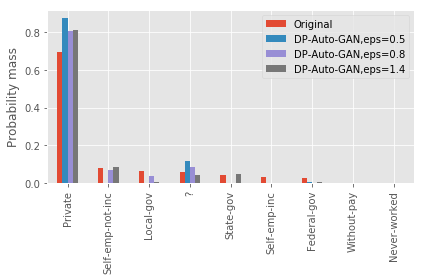

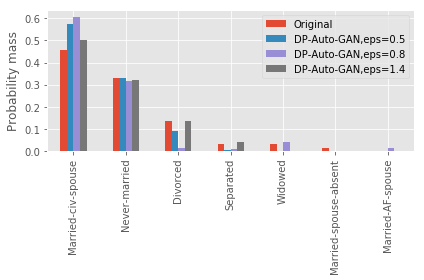

C:\Users\uthai\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


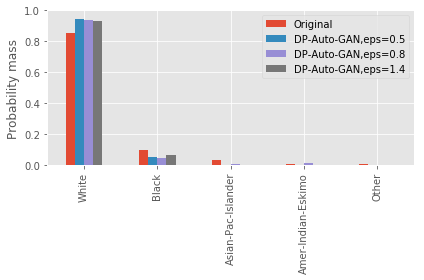

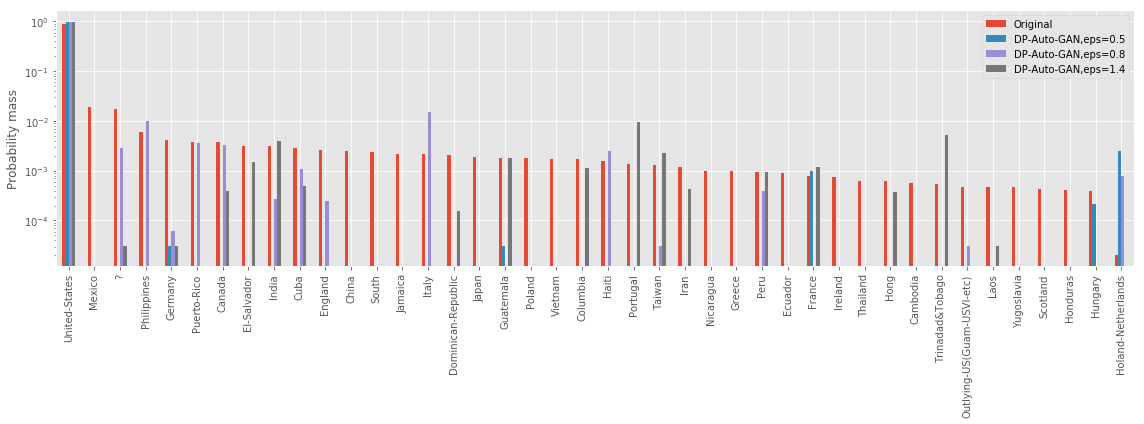

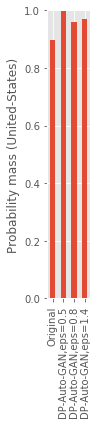

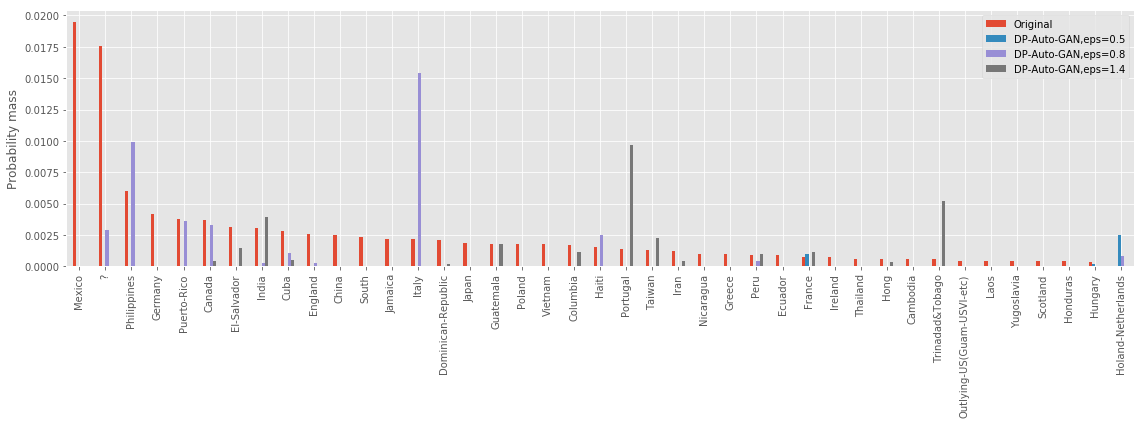

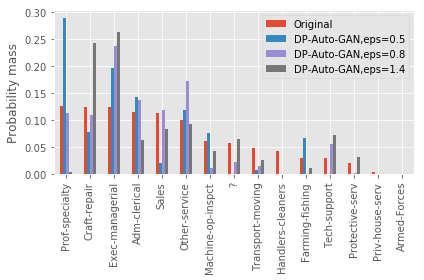

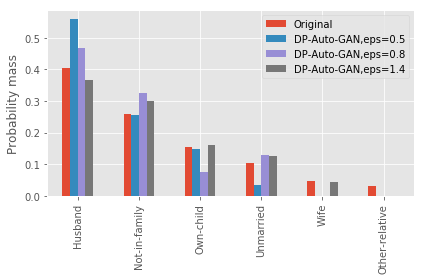

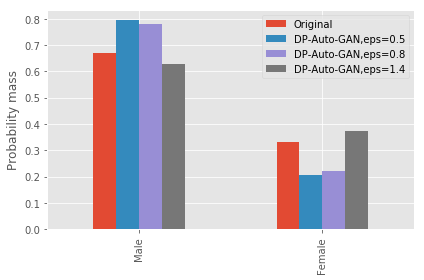

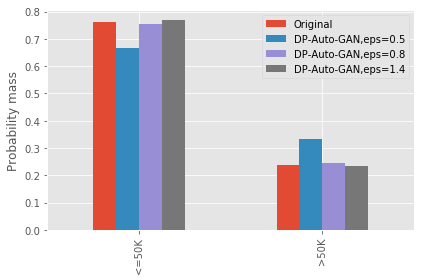

In [19]:
plot_by_eps(ori_df,ours_all,columns_hist,['DP-Auto-GAN,eps='+str(eps) for eps in [0.5,0.8,1.4]],prefix='hist_plot/auto-gan-')

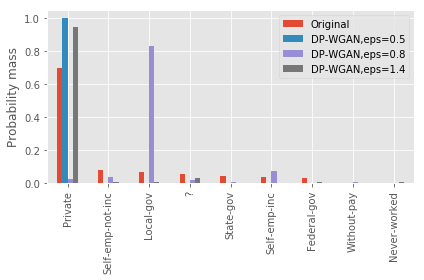

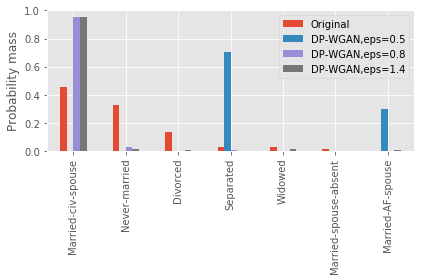

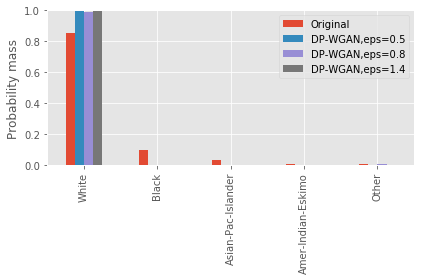

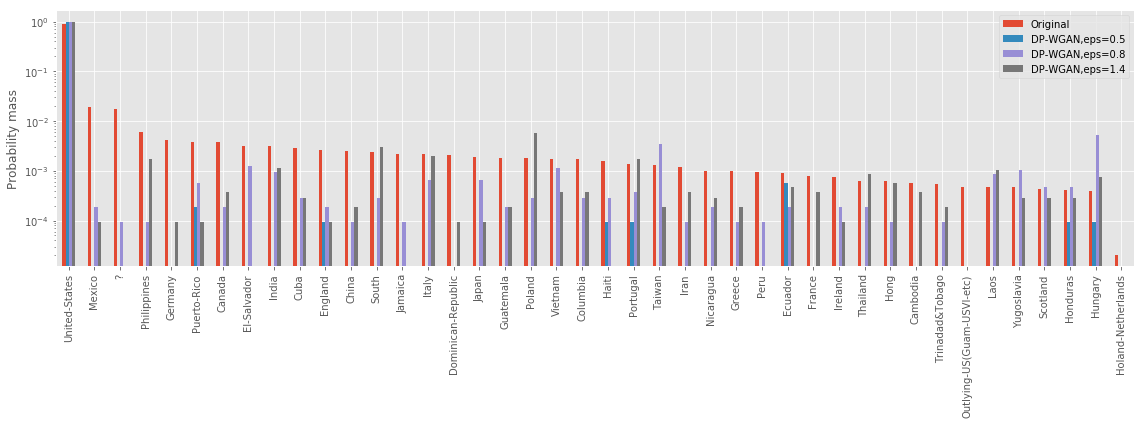

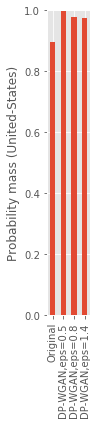

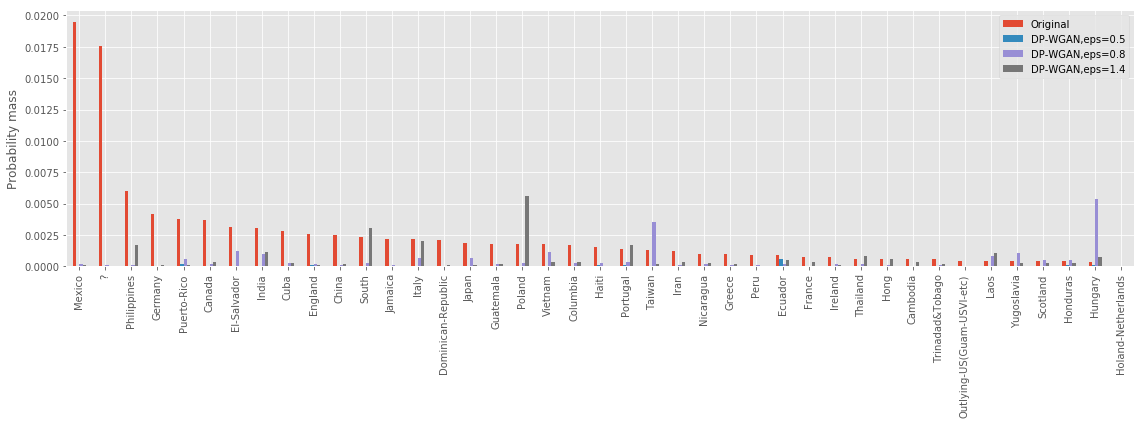

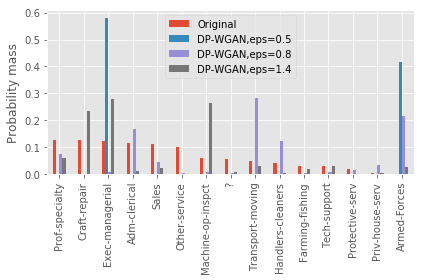

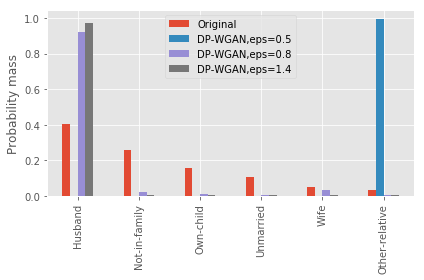

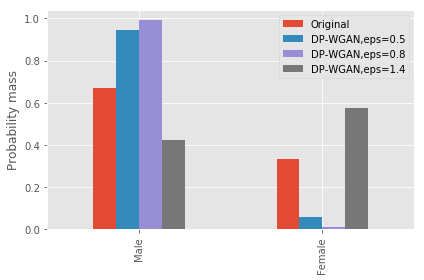

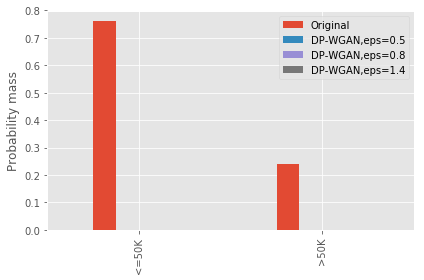

In [20]:
#larger value of eps for wgan
plot_by_eps(ori_df,wgan_all,columns_hist,['DP-WGAN,eps='+str(eps) for eps in [0.5,0.8,1.4]],prefix='hist_plot/wgan-')

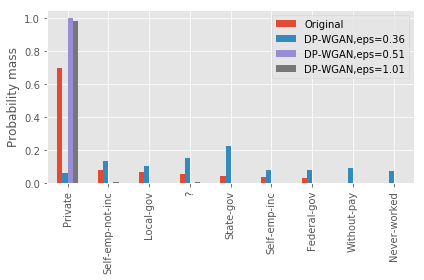

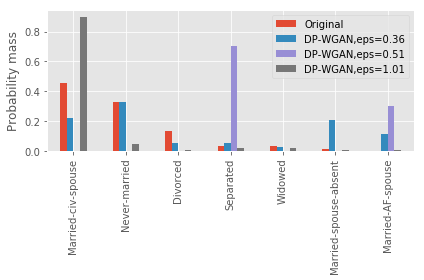

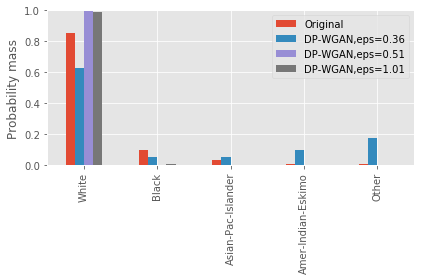

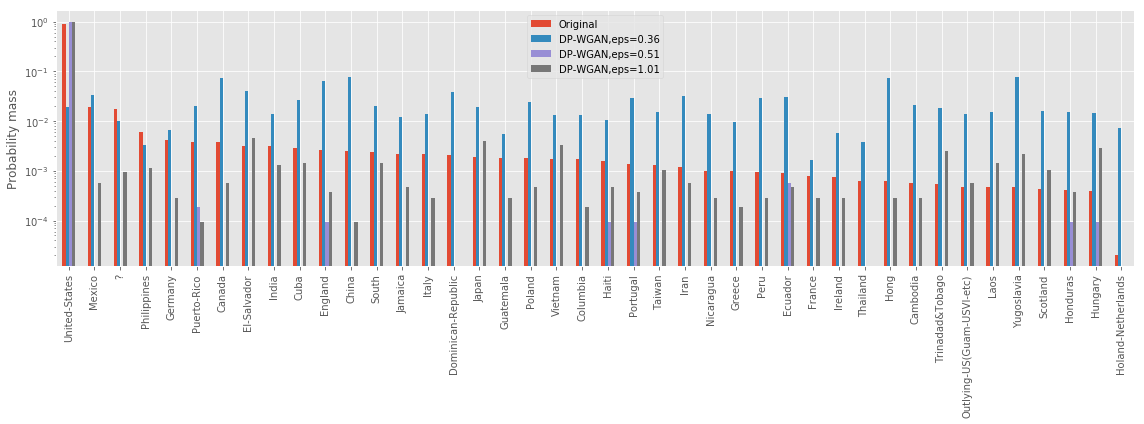

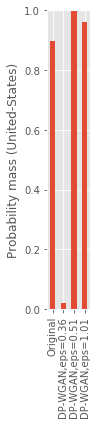

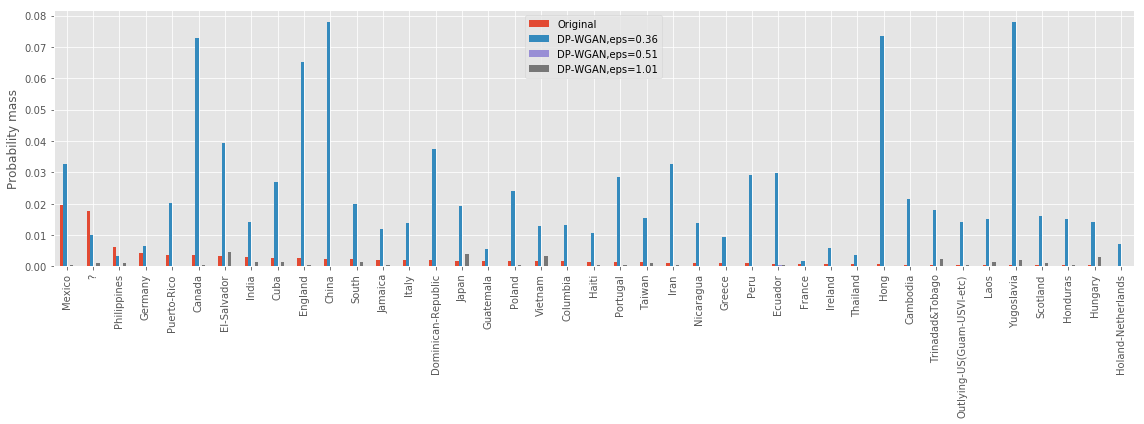

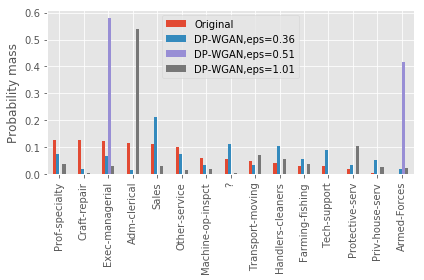

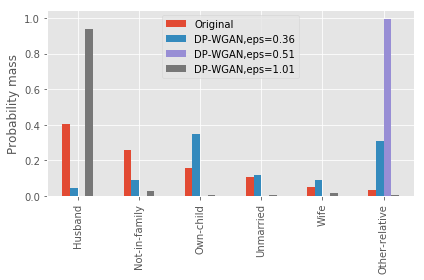

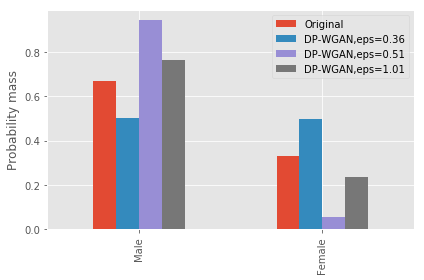

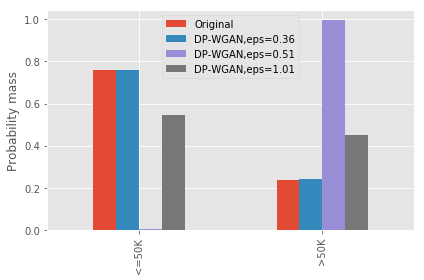

In [21]:
plot_by_eps(ori_df,wgan_all2,columns_hist,['DP-WGAN,eps='+str(eps) for eps in [0.36,0.51,1.01]],prefix='hist_plot/wgan-')

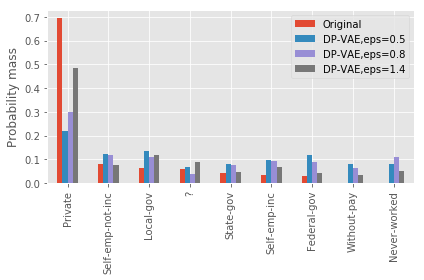

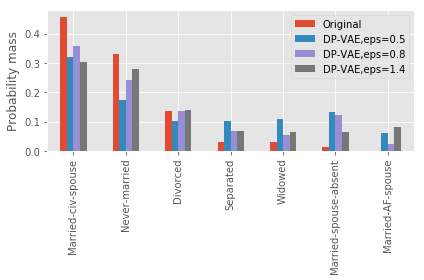

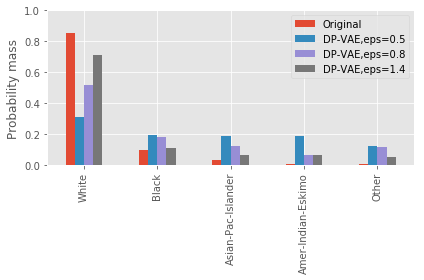

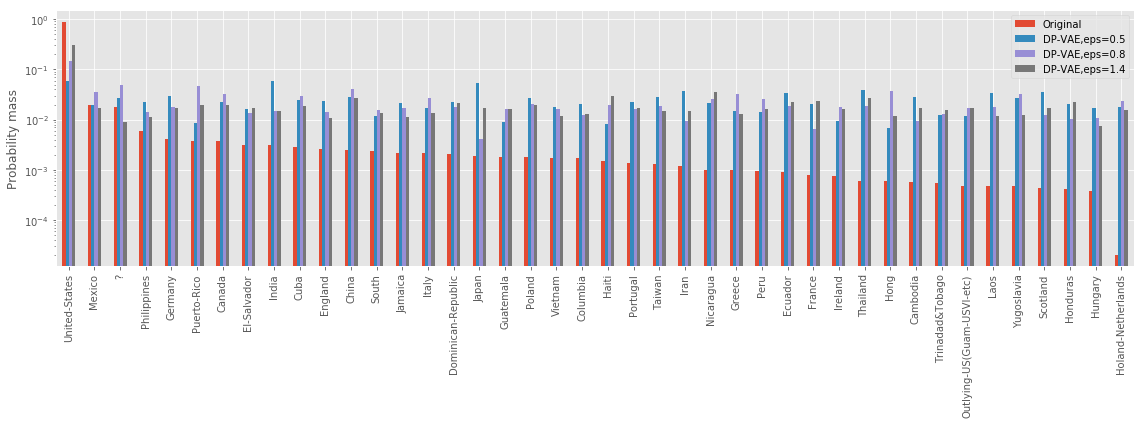

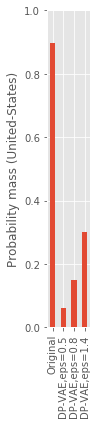

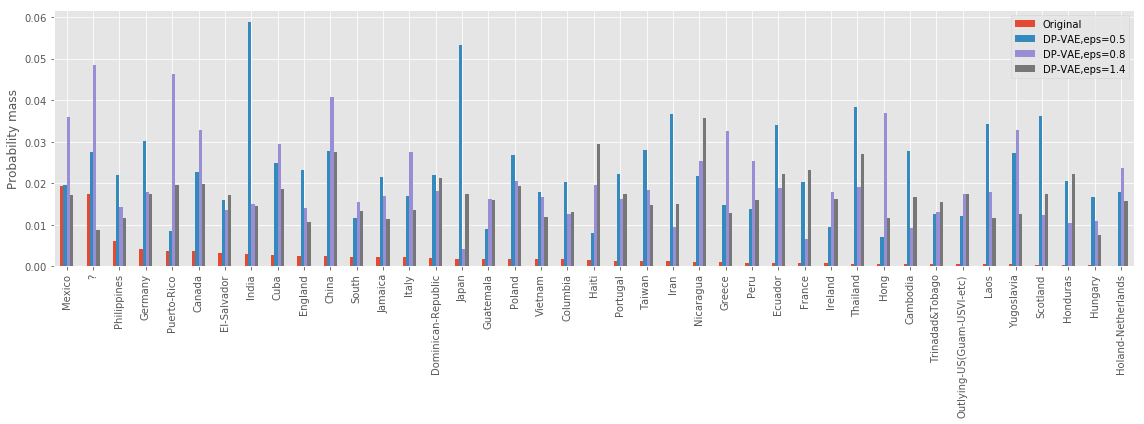

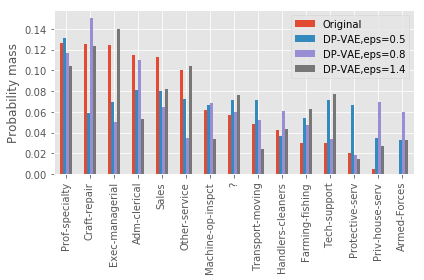

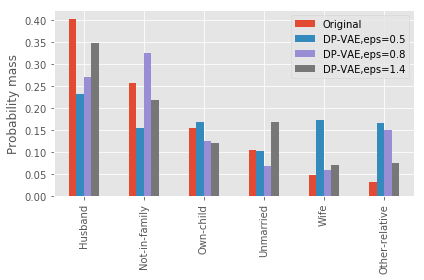

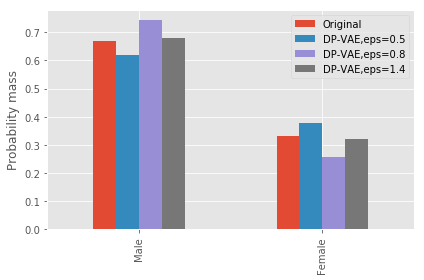

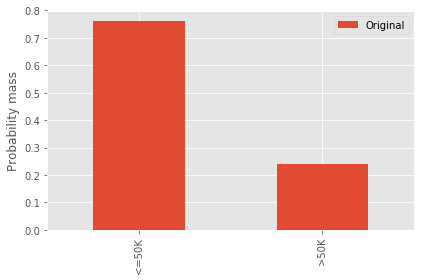

In [22]:
#DP-VAE of larger eps
plot_by_eps(ori_df,vae_all,columns_hist,['DP-VAE,eps='+str(eps) for eps in [0.5,0.8,1.4]],prefix='hist_plot/vae-')

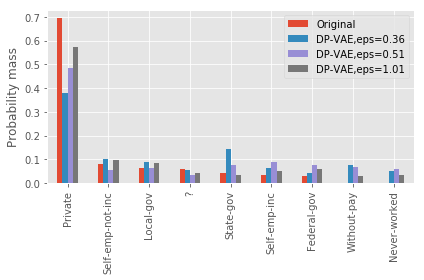

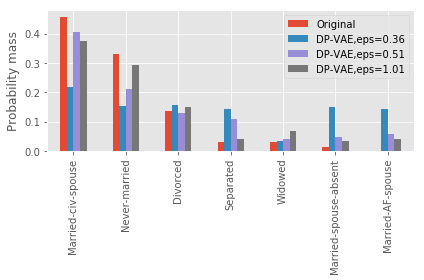

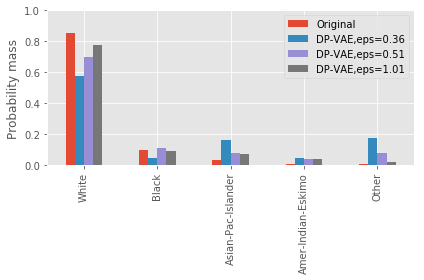

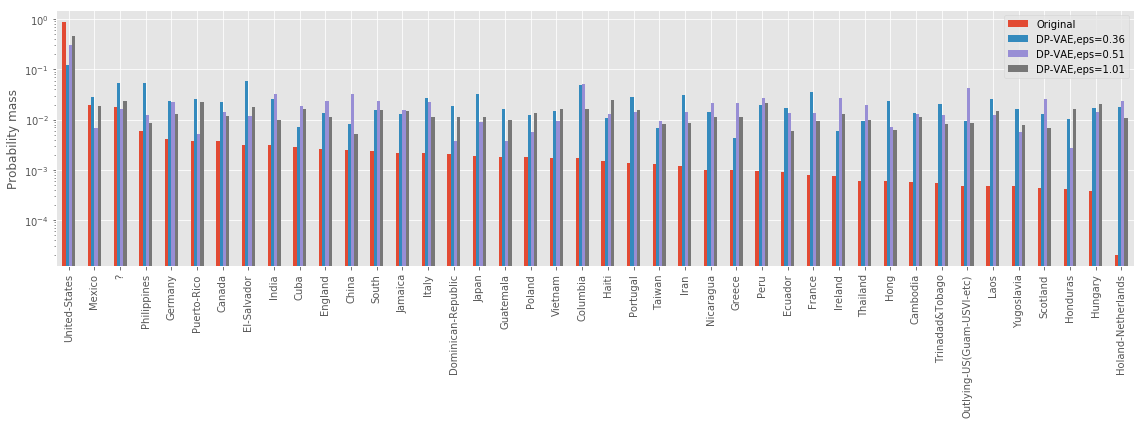

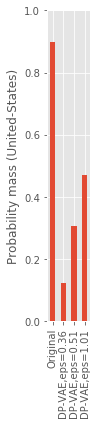

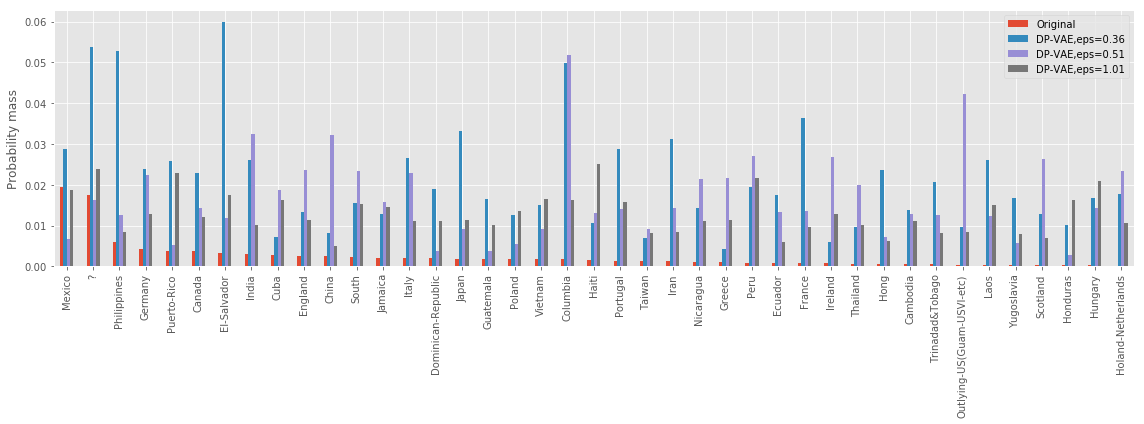

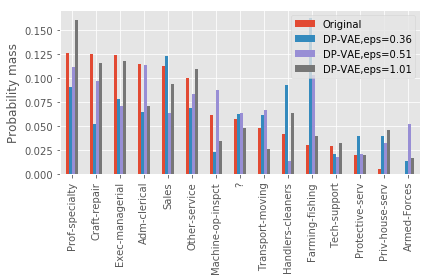

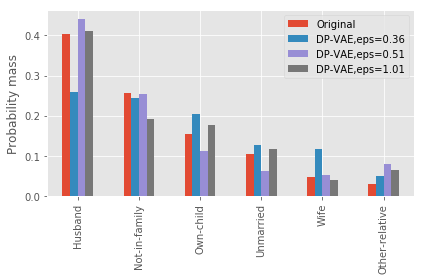

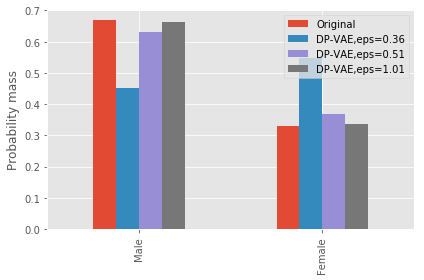

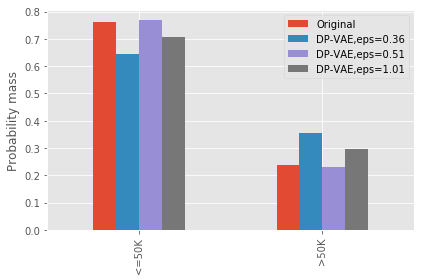

In [23]:
plot_by_eps(ori_df,vae_all2,columns_hist,['DP-VAE,eps='+str(eps) for eps in [0.36,0.51,1.01]],prefix='hist_plot/vae-')

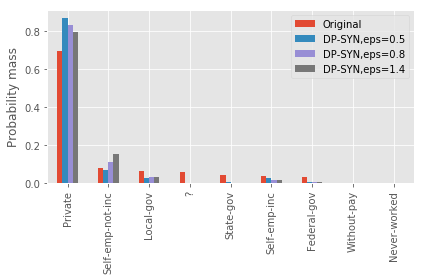

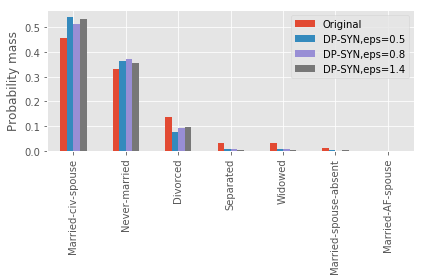

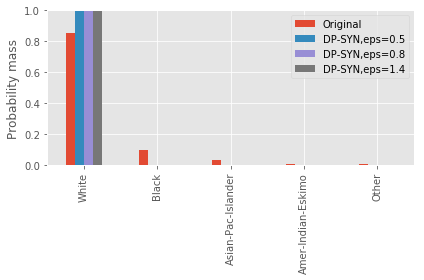

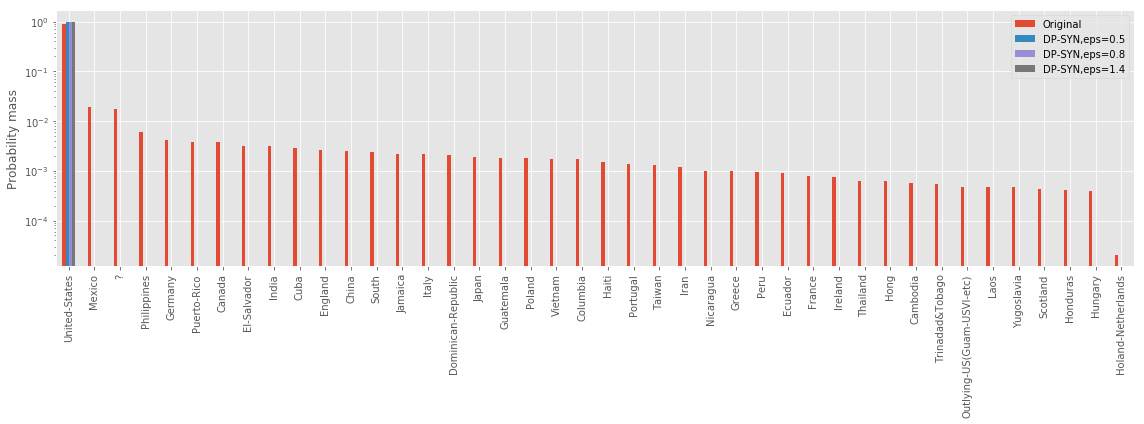

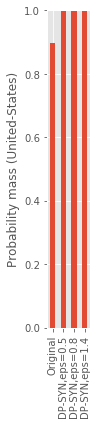

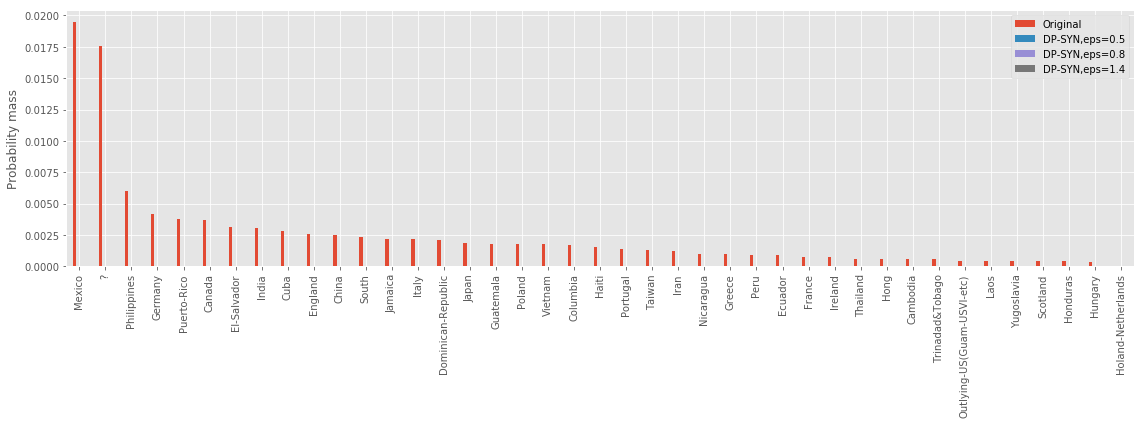

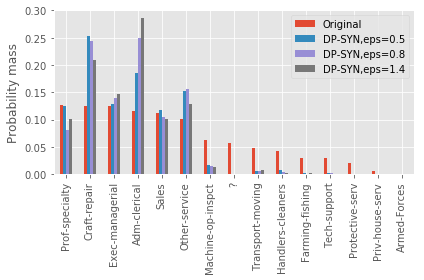

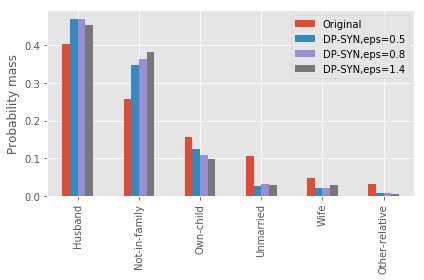

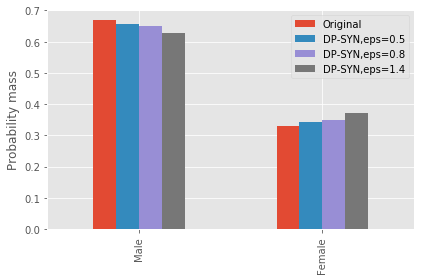

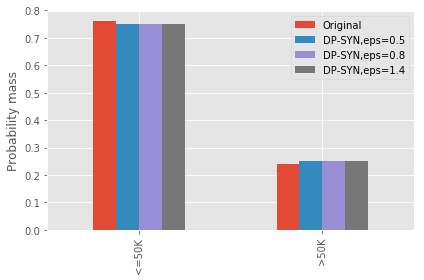

In [24]:
plot_by_eps(ori_df,abay_all,columns_hist,['DP-SYN,eps='+str(eps) for eps in [0.5,0.8,1.4]],prefix='hist_plot/abay')

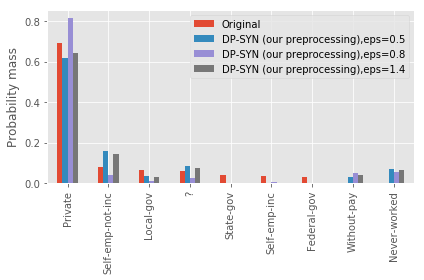

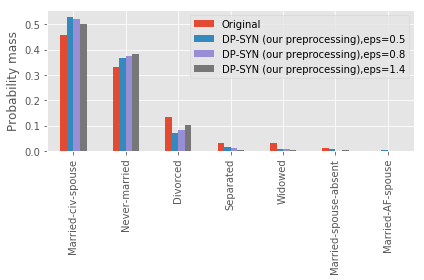

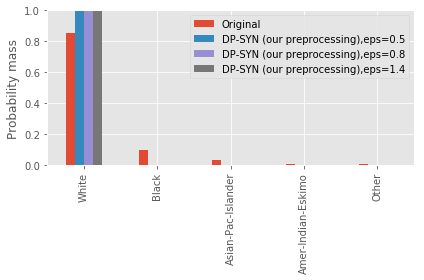

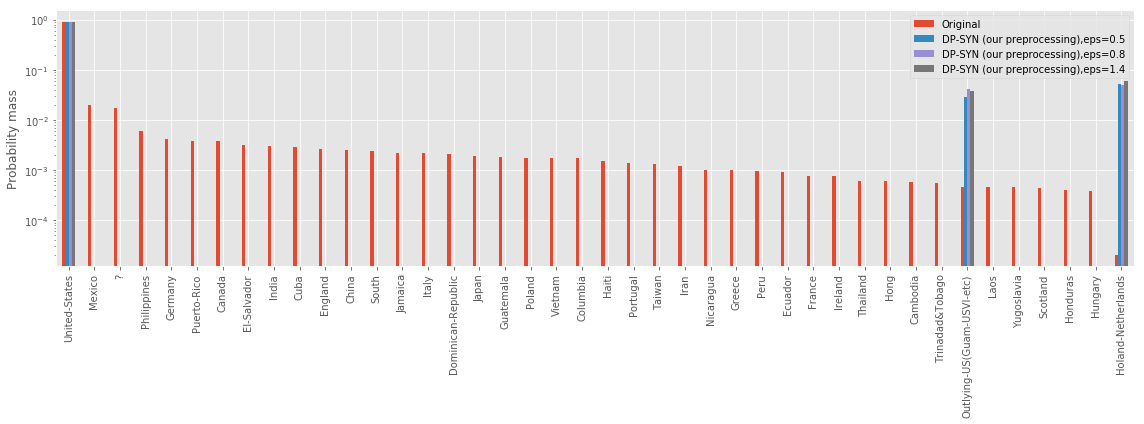

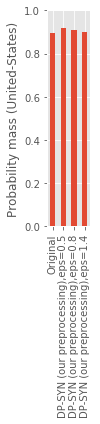

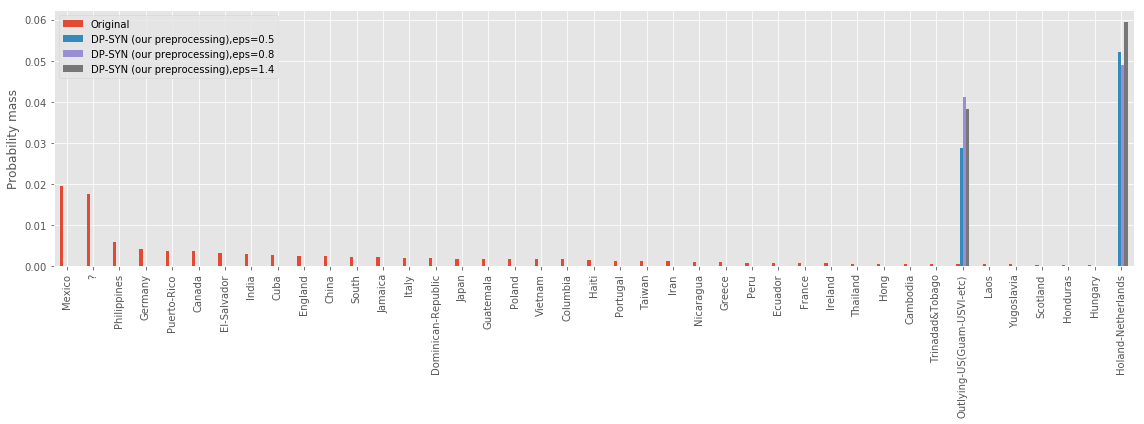

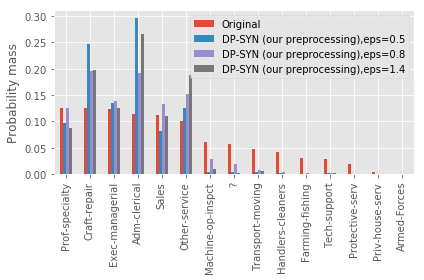

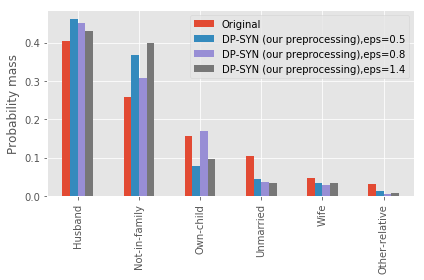

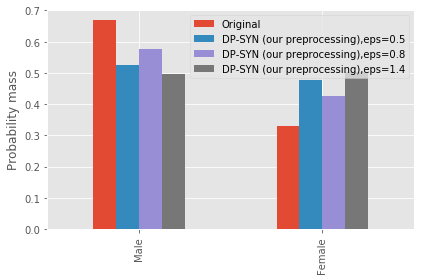

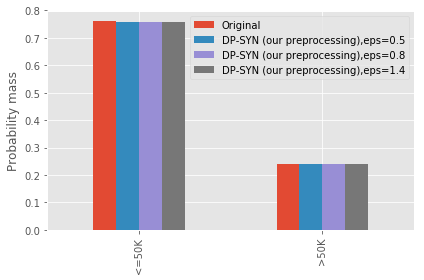

In [25]:
plot_by_eps(ori_df,abay_all_our_pre,columns_hist,['DP-SYN (our preprocessing),eps='+str(eps) for eps in [0.5,0.8,1.4]],prefix='hist_plot/abay_our_pre_')

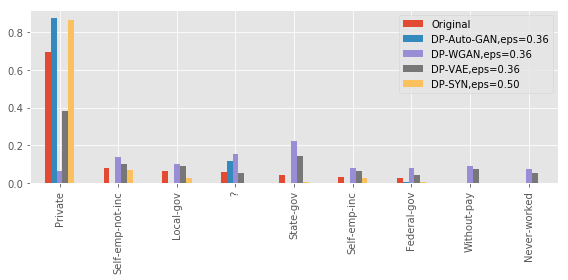

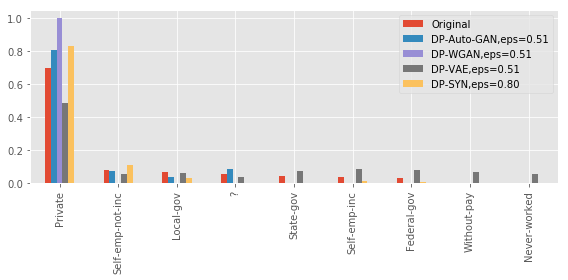

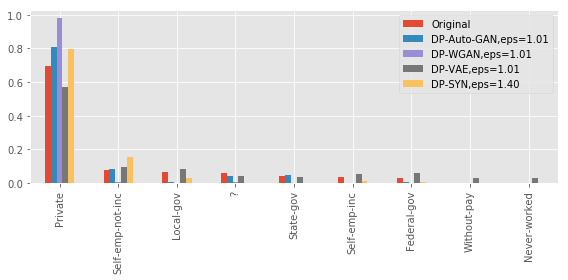

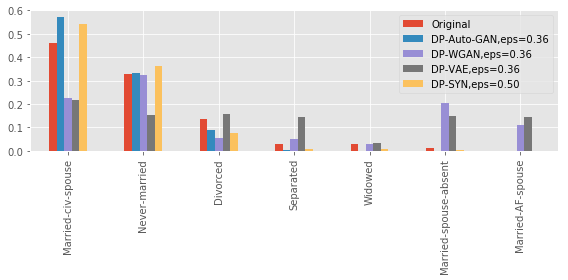

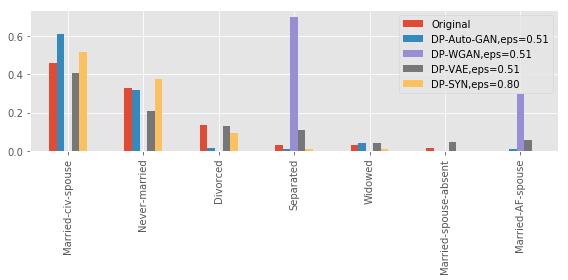

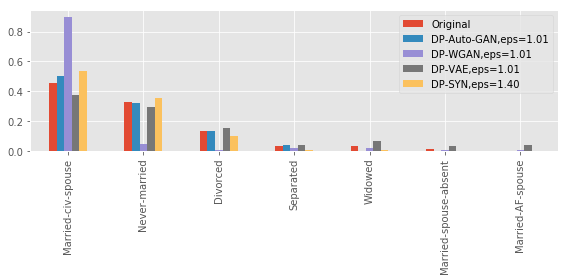

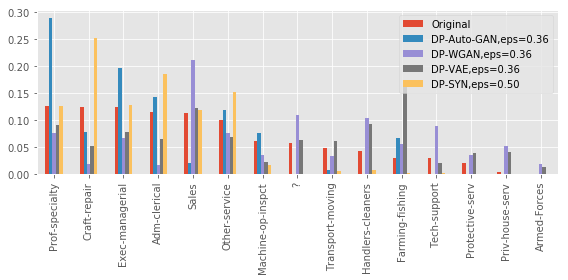

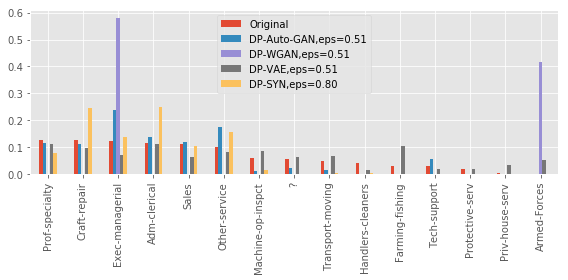

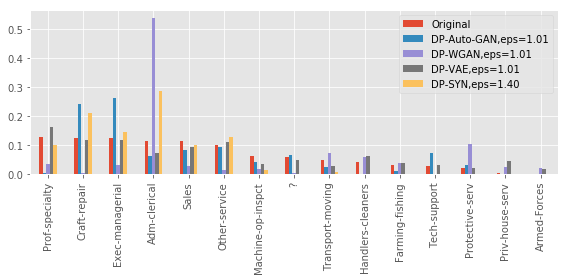

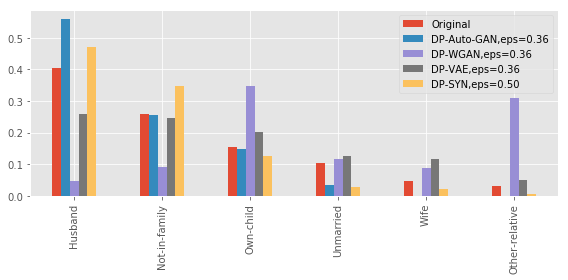

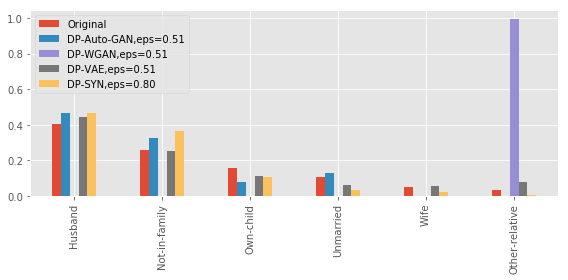

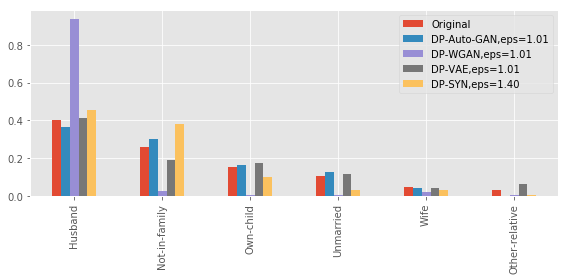

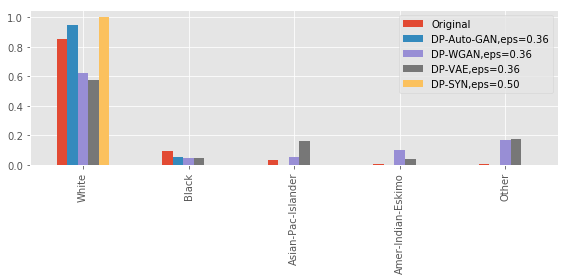

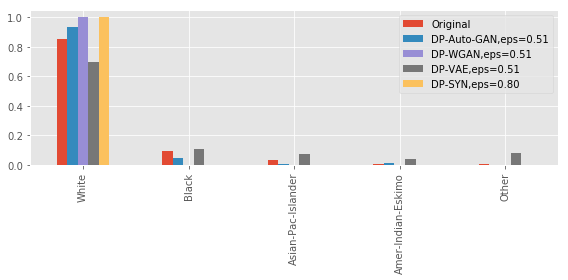

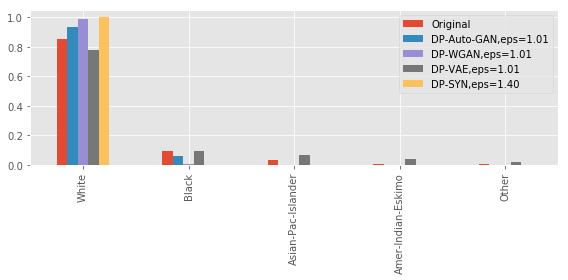

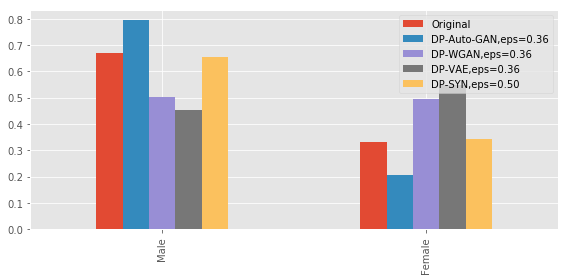

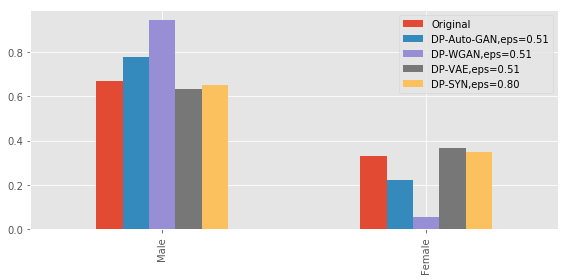

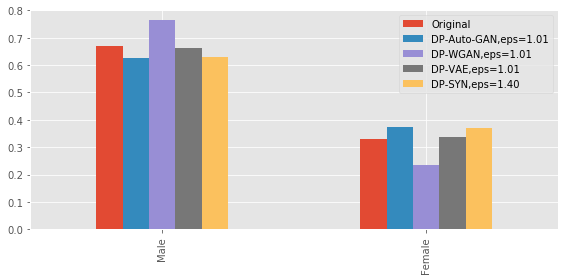

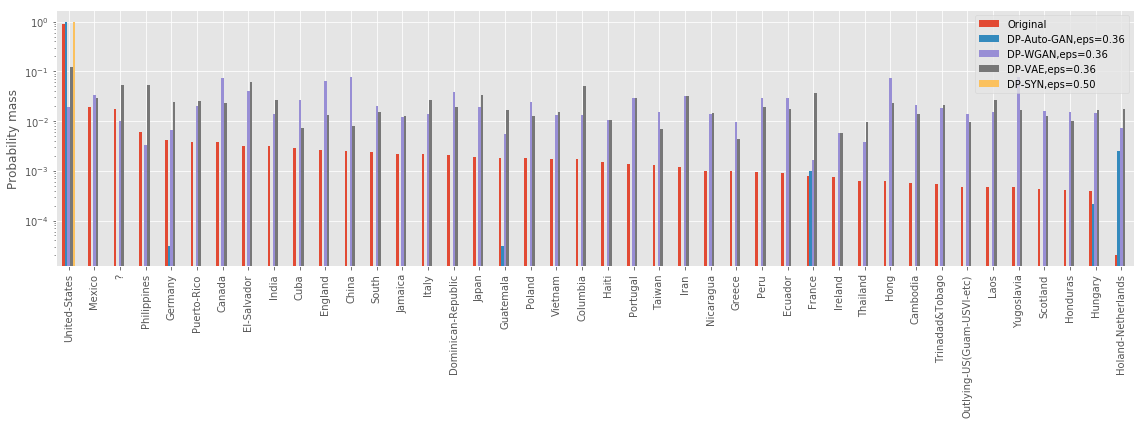

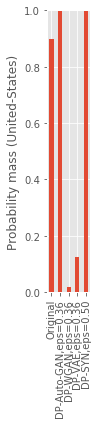

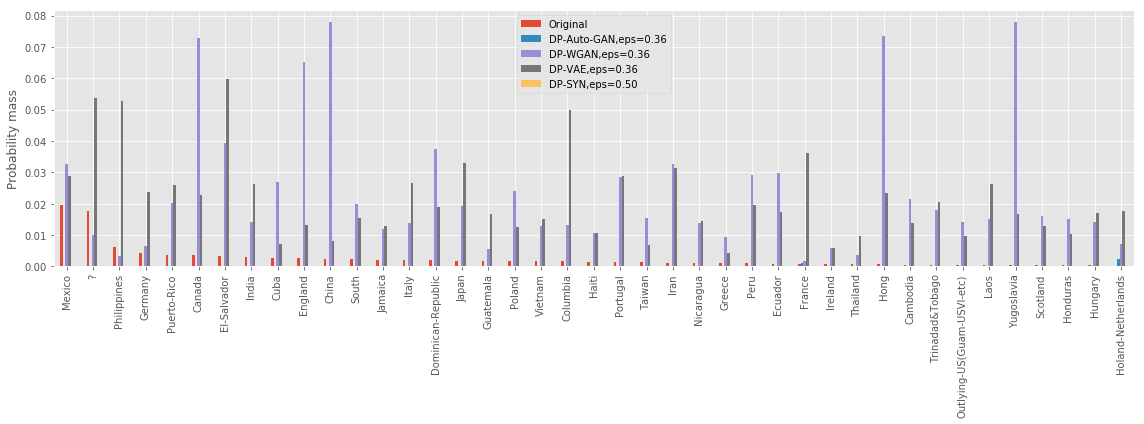

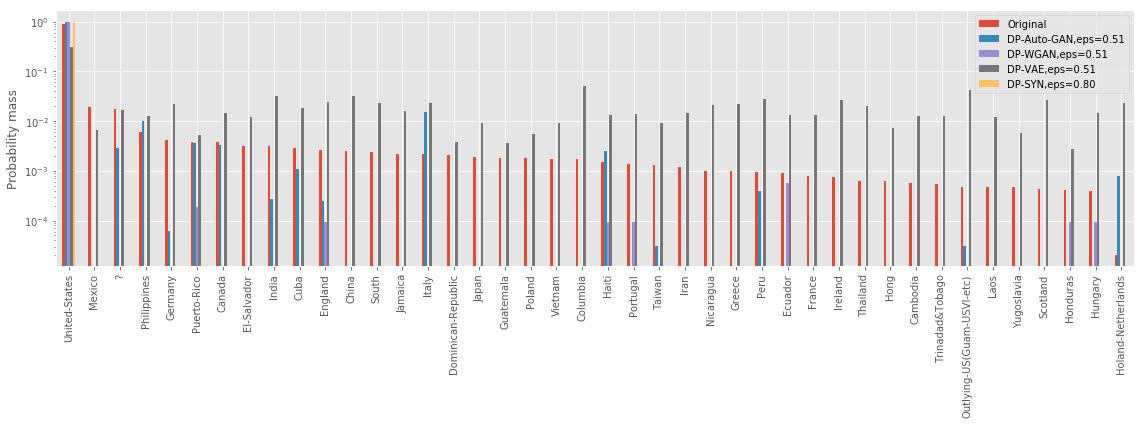

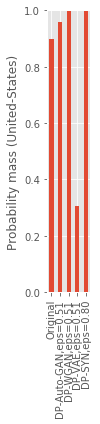

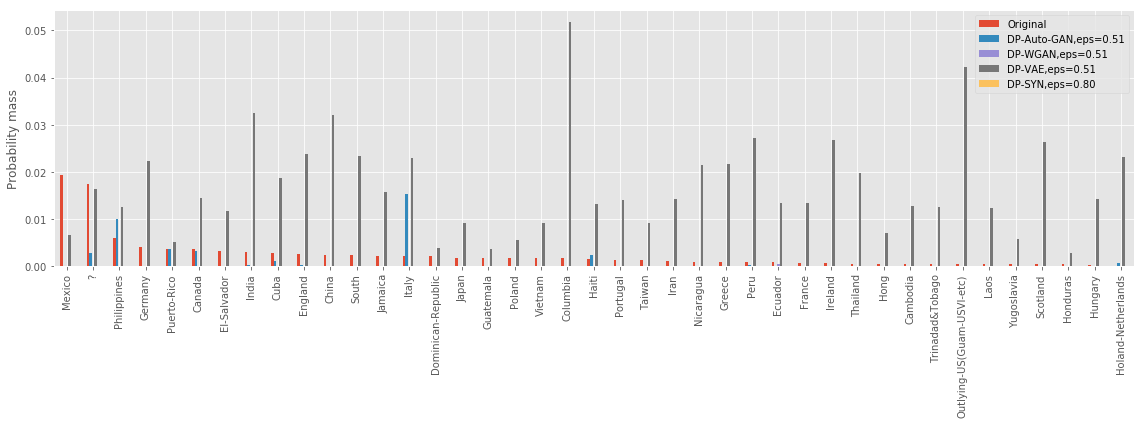

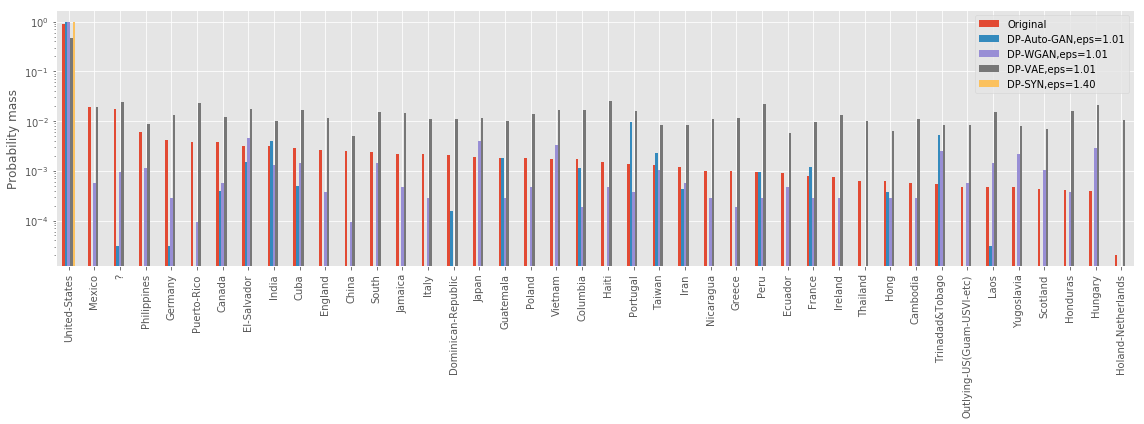

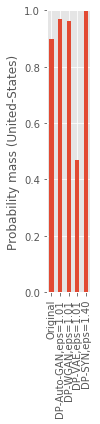

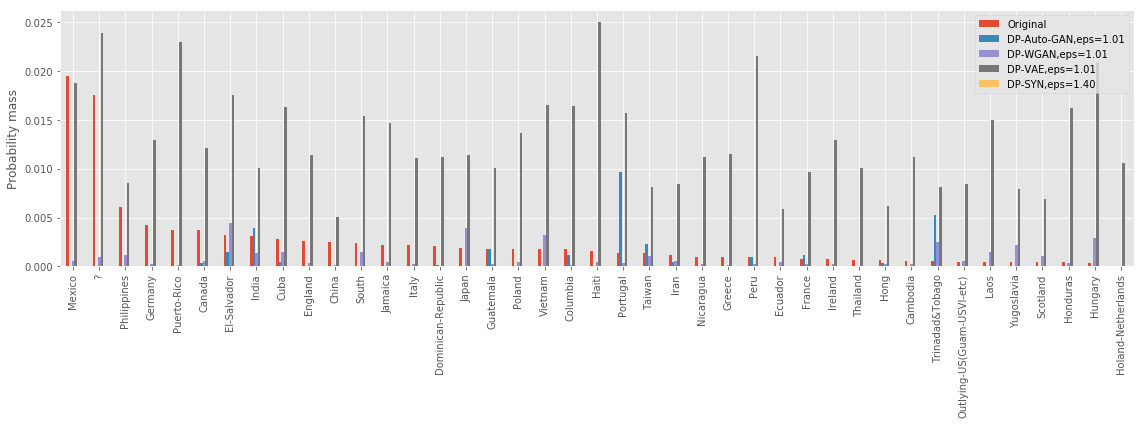

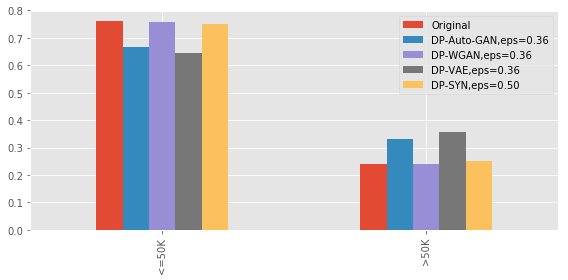

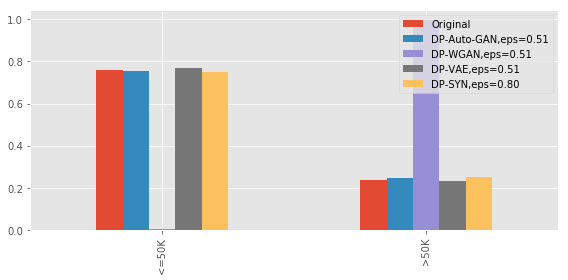

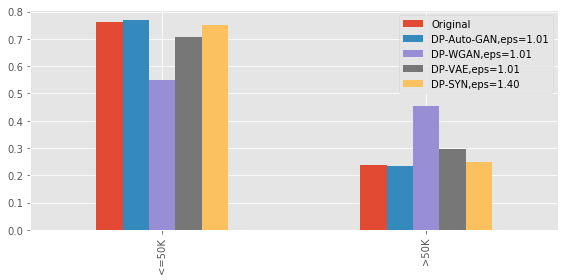

In [26]:
all_eps=[0.36,0.51,1.01] #three eps setting
other_eps = ['0.50','0.80','1.40']
for column in ['workclass', 'marital-status', 'occupation','relationship', 'race', 'sex', 'native-country', 'salary']:
    for i in range(len(all_eps)):
        freq = get_dist(ori_df,column).rename('Original').to_frame()\
            .join(get_dist(ours_all[i],column).rename('DP-Auto-GAN,eps='+str(all_eps[i])).to_frame())\
            .join(get_dist(wgan_all2[i],column).rename('DP-WGAN,eps='+str(all_eps[i])).to_frame())\
            .join(get_dist(vae_all2[i],column).rename('DP-VAE,eps='+str(all_eps[i])).to_frame())\
            .join(get_dist(abay_all[i],column).rename('DP-SYN,eps='+str(other_eps[i])).to_frame())
        if column == 'native-country': #require special treatment since one category is really high
            #log scale and longer plots due to many categories
            plot = freq.plot(kind='bar',figsize=(16,6))
            plot.set_yscale('log')
            plot.set_ylabel('Probability mass')
            plt.tight_layout()
            plt.savefig('hist_plot/combine_eps_'+str(all_eps[i])+'_'+column+'_log_scale.png',dpi=300)
            plt.show()
            
            #or try break the big one and small one
            
            freq_US = freq.loc['United-States']
            freq_others = freq.drop(['United-States'])
            freq_US.plot(kind='bar',figsize=(1.5,6)).set_ylabel('Probability mass (United-States)')
            plt.axes().set_ylim([0, 1])
            plt.tight_layout()
            plt.savefig('hist_plot/combine_eps_'+str(all_eps[i])+'_'+column+'_head.png',dpi=300)
            plt.show()
            
            freq_others.plot(kind='bar',figsize=(16,6)).set_ylabel('Probability mass')
            #plt.axes().set_ylim([0, 0.06])
            plt.tight_layout()
            plt.savefig('hist_plot/combine_eps_'+str(all_eps[i])+'_'+column+'_tail.png',dpi=300)
            plt.show()
            
            #plot1 = freq_US.plot(kind='bar',figsize=(16,4))
            #plot2 = freq_others.plot(kind='bar',figsize=(16,4))
        else:    
            freq.plot(kind='bar',figsize=(8, 4))
            plt.tight_layout()
            plt.savefig('hist_plot/combine_eps_'+str(all_eps[i])+'_'+column+'.png',dpi=300)        

C:\Users\uthai\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


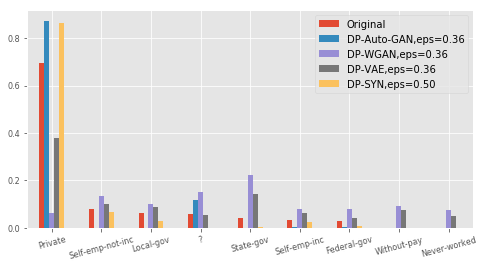

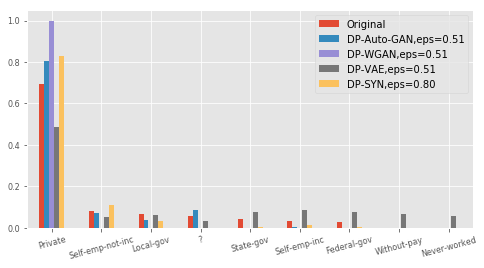

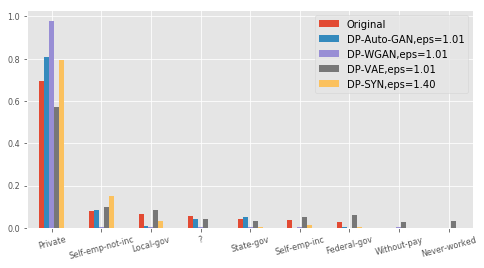

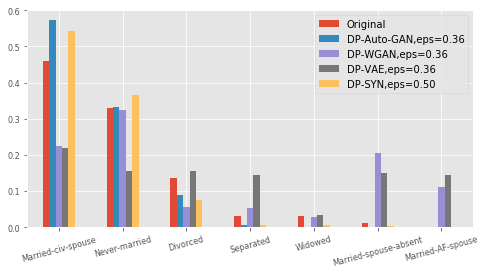

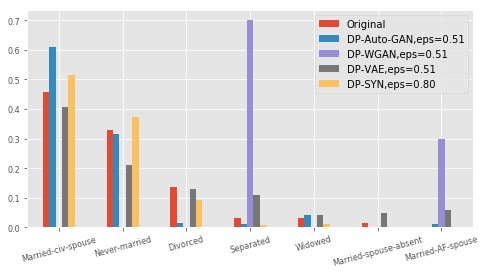

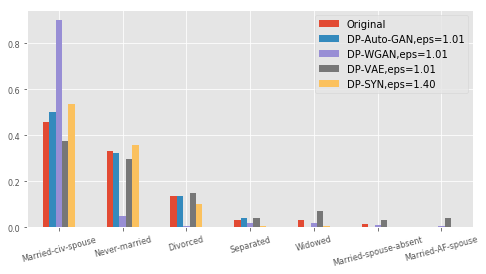

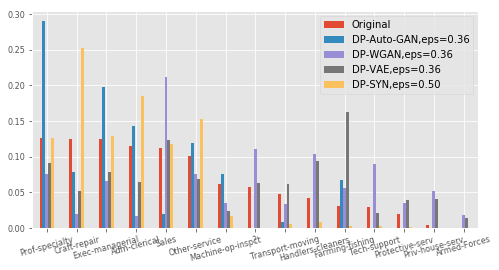

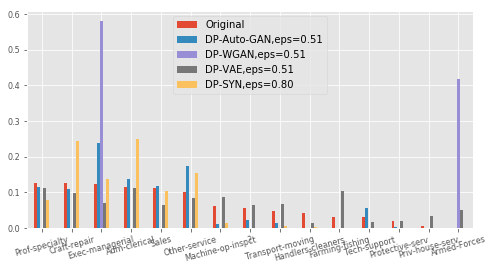

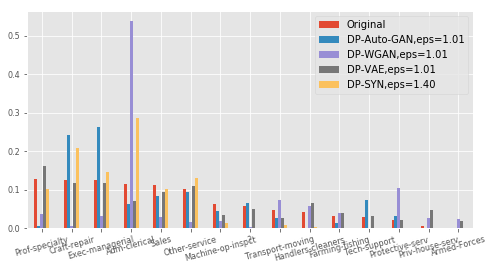

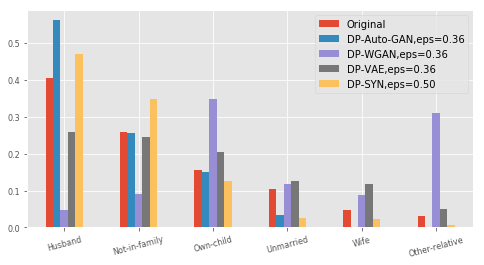

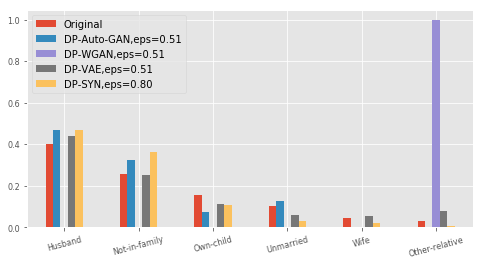

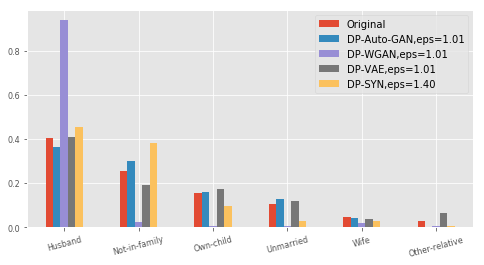

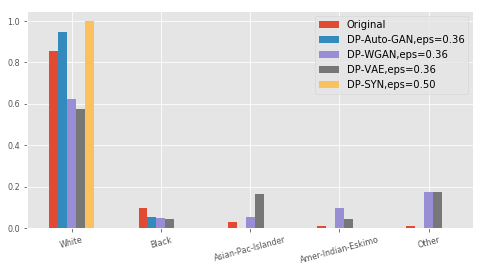

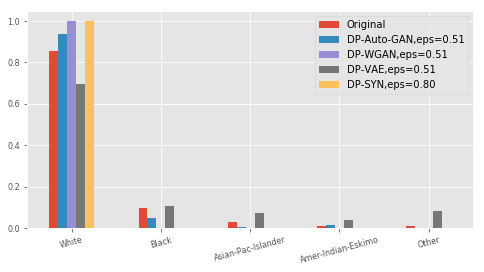

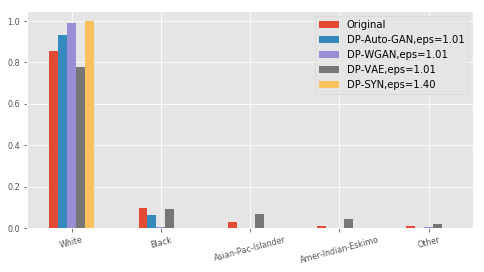

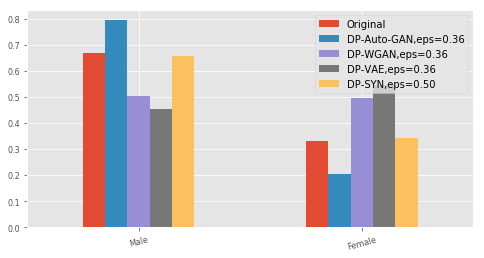

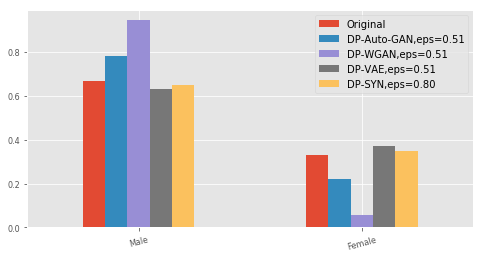

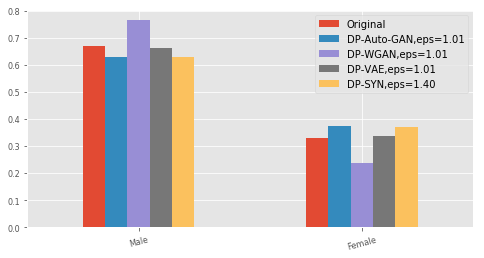

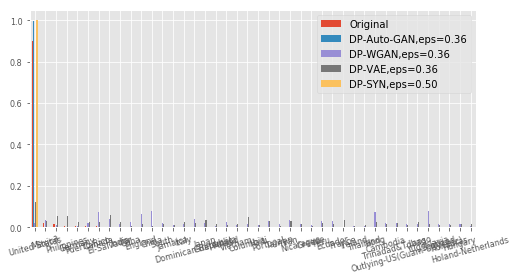

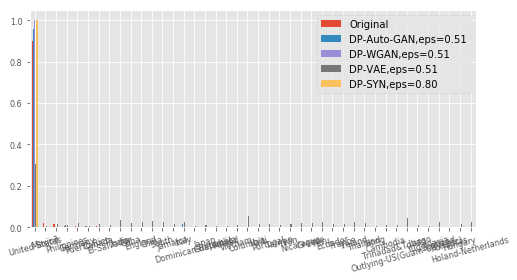

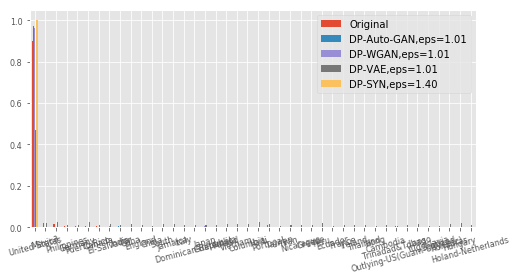

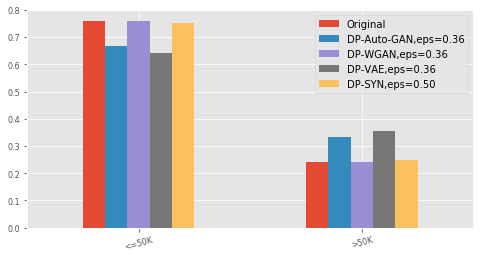

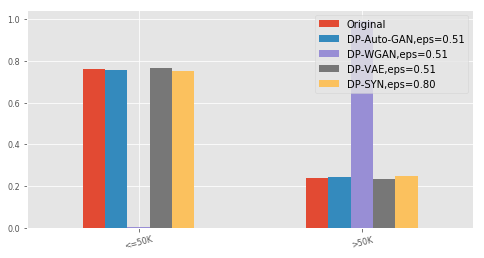

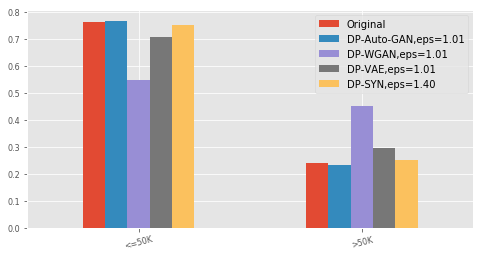

In [27]:
all_eps=[0.36,0.51,1.01] #three eps setting
other_eps = ['0.50','0.80','1.40']
for column in ['workclass', 'marital-status', 'occupation','relationship', 'race', 'sex', 'native-country', 'salary']:
    for i in range(len(all_eps)):
        freq = get_dist(ori_df,column).rename('Original').to_frame()\
            .join(get_dist(ours_all[i],column).rename('DP-Auto-GAN,eps='+str(all_eps[i])).to_frame())\
            .join(get_dist(wgan_all2[i],column).rename('DP-WGAN,eps='+str(all_eps[i])).to_frame())\
            .join(get_dist(vae_all2[i],column).rename('DP-VAE,eps='+str(all_eps[i])).to_frame())\
            .join(get_dist(abay_all[i],column).rename('DP-SYN,eps='+str(other_eps[i])).to_frame())
        freq.plot(kind='bar',figsize=(8, 4),fontsize=8)      
        plt.xticks(list(range(len(freq))), freq.index.values, rotation=15)
        #plt.tight_layout()
        plt.savefig('hist_plot/combine_x-adj_eps_'+str(all_eps[i])+'_'+column+'.png',dpi=300)        

# Diversity measure

In [31]:
import math
def get_divergence_score(df, ori_df, column, mu=None, penalize=1):
    divergence = 0
    #mu = math.e**(-len(map_forward_ori[column]))
    p1 = max(get_dist(ori_df,column))
    if p1 > 0.999999: print("warning: max distribution of original data with column",column,"is","p1","which is too close to 1 or is 1.")
    mu = math.e**(-penalize/(1-p1))
    for key in map_forward_ori[column]:    
        key = str.strip(key)
        p = get_dist(ori_df,column)[key] if key in get_dist(ori_df,column) else 0
        q = get_dist(df,column)[key] if key in get_dist(df,column) else 0
        #print(key,p,q)
        divergence += (p+mu)*math.log((p+mu)/(q+mu))
        #print(divergence)
    return divergence

In [49]:
def get_JS_score(df, ori_df, column, mu=0):
    divergence = 0
    for key in map_forward_ori[column]:    
        key = str.strip(key)
        p = get_dist(ori_df,column)[key] if key in get_dist(ori_df,column) else 0
        q = get_dist(df,column)[key] if key in get_dist(df,column) else 0
        m = (p+q)/2
        #print(key,p,q,m)
        divergence += (p+mu)*math.log((p+mu)/(m+mu))/2 if p+mu>0 else 0
        divergence += (q+mu)*math.log((q+mu)/(m+mu))/2 if q+mu>0 else 0
        #print(divergence)
    return divergence

In [46]:
#example
print(get_divergence_score(ori_df,ours_all[0],'race'))
print(get_JS_score(ori_df,ours_all[0],'race'))

0.06446557561529268
Amer-Indian-Eskimo 3.071064430931761e-05 0.009622865566520618 0.004826788105414968
Asian-Pac-Islander 0 0.031100282543712377 0.015550141271856189
Black 0.0538971807628524 0.09592154293435977 0.07490936184860608
Other 0 0.0083125179149093 0.00415625895745465
White 0.9460721085928383 0.855042791040498 0.9005574498166682
0.0210390253721765


In [47]:
if not os.path.isdir('diversity_divergence'):
    os.makedirs('diversity_divergence')

all_eps=[0.36,0.51,1.01] #three eps setting
df_all = dict() # of table of scores. one  column, one table
for penalize in [1,2,3,4,5]:
    for column in ['workclass', 'marital-status', 'occupation','relationship', 'race', 'sex', 'native-country', 'salary']:
        print(column)
        df_all[column] = pd.DataFrame(columns=['alg','0.36','0.51','1.01'])

        data = [ours_all,wgan_all2,vae_all2,abay_all,abay_all_our_pre]
        name_alg = ['DP-auto-GAN','DP-WGAN','DP-VAE','DP-SYN','DP-SYN-our-pre']

        for i in range(len(data)):
            df = data[i]
            row = [name_alg[i]]
            for j in range(len(all_eps)):
                score = get_divergence_score(df[j],ori_df,column,penalize=penalize)
                row.append(score)
            df_all[column].loc[len(df_all[column])]=row #append a row of this score


        df_all[column] = df_all[column].set_index('alg')

        print(df_all[column])
        df_all[column].to_csv('diversity_divergence/diversity_penalize_'+str(penalize)+'_'+column+'.csv')

    #sum
    sum_df = df_all[column]*0
    for column in df_all:
        sum_df += df_all[column]
    sum_df.to_csv('diversity_divergence/diversity_penalize_'+str(penalize)+'_total.csv')
    print('sum of divergences')
    print(sum_df)
        

workclass
                    0.36      0.51      1.01
alg                                         
DP-auto-GAN     0.154607  0.053647  0.055176
DP-WGAN         1.046375  0.207735  0.176765
DP-VAE          0.195555  0.123988  0.039170
DP-SYN          0.073966  0.073766  0.083965
DP-SYN-our-pre  0.102941  0.123126  0.099151
marital-status


KeyboardInterrupt: 

In [ ]:
#printing into latex format
df_div = dict()
smallest = dict() #for each column, store 3 argmin for 3 eps settings
for column in ['workclass', 'marital-status', 'occupation','relationship', 'race', 'sex', 'native-country', 'salary']:
    pen = 1
    #read data and get rid of the last column! because it's DP-SYN our preprocessing
    df_div[column] = pd.read_csv('diversity_divergence/diversity_penalize_'+str(pen)+'_'+column+'.csv').drop(columns='alg').iloc[:-1,:].values
    #get where to bold the minimum
    print(df_div[column])
    smallest[column] = np.argmin(df_div[column],axis=0)
    print(smallest[column])
string = ''
for column in df_div:
    string_row = column
    for i in range(len(df_div[column])):
        for j in range(len(df_div[column][i])):
            num = df_div[column][i][j]
            if smallest[column][j] == i: #bold this
                string_row += ' & ' + "\\textbf{" + f"{num:.3f}" + "}"
            else:
                string_row += ' & ' + f"{num:.3f}"
        
    string = string_row + ' \\\\ \hline'
    print(string)


In [51]:
if not os.path.isdir('JS_divergence'):
    os.makedirs('JS_divergence')

all_eps=[0.36,0.51,1.01] #three eps setting
df_all = dict() # of table of scores. one  column, one table
for column in ['workclass', 'marital-status', 'occupation','relationship', 'race', 'sex', 'native-country', 'salary']:
    print(column)
    df_all[column] = pd.DataFrame(columns=['alg','0.36','0.51','1.01'])

    data = [ours_all,wgan_all2,vae_all2,abay_all,abay_all_our_pre]
    name_alg = ['DP-auto-GAN','DP-WGAN','DP-VAE','DP-SYN','DP-SYN-our-pre']

    for i in range(len(data)):
        df = data[i]
        row = [name_alg[i]]
        for j in range(len(all_eps)):
            score = get_JS_score(df[j],ori_df,column)
            row.append(score)
        df_all[column].loc[len(df_all[column])]=row #append a row of this score


    df_all[column] = df_all[column].set_index('alg')

    print(df_all[column])
    df_all[column].to_csv('JS_divergence/diversity_penalize_'+str(penalize)+'_'+column+'.csv')

#sum
sum_df = df_all[column]*0
for column in df_all:
    sum_df += df_all[column]
sum_df.to_csv('JS_divergence/diversity_penalize_'+str(penalize)+'_total.csv')
print('sum of JS divergences')
print(sum_df)
        

workclass
                    0.36      0.51      1.01
alg                                         
DP-auto-GAN     0.086470  0.039530  0.032443
DP-WGAN         0.270804  0.118922  0.090274
DP-VAE          0.085332  0.067269  0.027935
DP-SYN          0.040297  0.043165  0.048291
DP-SYN-our-pre  0.073073  0.084222  0.073764
marital-status
                    0.36      0.51      1.01
alg                                         
DP-auto-GAN     0.025197  0.043311  0.014132
DP-WGAN         0.118677  0.624111  0.135750
DP-VAE          0.139158  0.042734  0.020952
DP-SYN          0.016958  0.012530  0.017247
DP-SYN-our-pre  0.014301  0.015028  0.015435
occupation
                    0.36      0.51      1.01
alg                                         
DP-auto-GAN     0.107061  0.064112  0.088727
DP-WGAN         0.099690  0.521783  0.227514
DP-VAE          0.066002  0.048413  0.024185
DP-SYN          0.080981  0.098653  0.098275
DP-SYN-our-pre  0.110484  0.060798  0.100105
relationship
      

In [5]:
#printing into latex format
df_div = dict()
smallest = dict() #for each column, store 3 argmin for 3 eps settings
for column in ['workclass', 'marital-status', 'occupation','relationship', 'race', 'sex', 'native-country', 'salary']:
    pen = 1
    #read data and get rid of the last column! because it's DP-SYN our preprocessing
    df_div[column] = pd.read_csv('JS_divergence/diversity_penalize_'+str(pen)+'_'+column+'.csv').drop(columns='alg').iloc[:-1,:].values
    #get where to bold the minimum
    print(df_div[column])
    smallest[column] = np.argmin(df_div[column],axis=0)
    print(smallest[column])
string = ''
for column in df_div:
    string_row = column
    if column == 'salary':
        string_row += ' x 100'
    for i in range(len(df_div[column])):
        for j in range(len(df_div[column][i])):
            num = df_div[column][i][j]
            if column == 'salary':
                num *= 100
            num_str = f"{num:.3f}"
            if num < 1:
                num_str = num_str[1:] #delete first 0 before decimal place
            if smallest[column][j] == i: #bold this
                string_row += ' & ' + "\\textbf{" + num_str + "}"
            else:
                string_row += ' & ' + num_str
        
    string = string_row + ' \\\\ \hline'
    print(string)


[[0.08647007 0.03953026 0.0324427 ]
 [0.27080396 0.11892165 0.09027442]
 [0.08533196 0.06726868 0.02793509]
 [0.04029675 0.04316527 0.04829146]]
[3 0 2]
[[0.02519656 0.04331129 0.01413201]
 [0.11867713 0.62411137 0.13574963]
 [0.13915839 0.04273358 0.02095226]
 [0.01695836 0.01252987 0.01724708]]
[3 3 0]
[[0.10706106 0.06411188 0.08872726]
 [0.09969043 0.52178284 0.22751414]
 [0.06600249 0.04841328 0.02418545]
 [0.08098099 0.09865297 0.09827513]]
[2 2 2]
[[0.04233134 0.03470349 0.01079915]
 [0.19022694 0.61391526 0.18742825]
 [0.01862477 0.01056504 0.00612889]
 [0.02403253 0.02494987 0.02752169]]
[2 2 2]
[[0.02103903 0.01363766 0.01561573]
 [0.08133406 0.05307305 0.03988138]
 [0.09460413 0.03092298 0.01120933]
 [0.05307305 0.05307305 0.05307305]]
[0 0 2]
[[1.00801984e-02 7.62657724e-03 9.44990228e-04]
 [1.41424258e-02 6.56819702e-02 5.62059185e-03]
 [2.37321132e-02 7.65690753e-04 1.64954113e-05]
 [8.13246500e-05 1.71668518e-04 8.45982553e-04]]
[3 3 2]
[[0.03710925 0.02828006 0.03226901